In [2]:
import os
import glob
import re
import pandas as pd
import shutil
import zipfile
import geopandas as gpd
import requests
import json
import numpy as np
import _config

In [10]:
df_projects                     = _config.df_projects
tdm_model                       = _config.tdm_model
tdm_transit_scenarios           = _config.tdm_transit_scenarios
input_model_line_files_folder   = _config.input_model_line_files_folder
input_tdm_link_shapefile_folder = _config.input_tdm_link_shapefile_folder
tdm_link_shapefile              = _config.tdm_link_shapefile
tdm_node_shapefile              = _config.tdm_node_shapefile
input_tdm_node_shapefile_folder = _config.input_tdm_node_shapefile_folder
df_centers                      = _config.df_centers
input_taz_shapefile_folder      = _config.input_taz_shapefile_folder
taz_shapefile                   = _config.taz_shapefile
df_center_override              = _config.df_center_override

In [13]:
# Get transit line link data for projects

_df_transit_lin_files = pd.read_csv(os.path.join(input_model_line_files_folder, 'files.csv'))
_df_transit_lin_files_lines = pd.read_csv(os.path.join(input_model_line_files_folder, 'lines.csv'))
_df_transit_lin_files_links = pd.read_csv(os.path.join(input_model_line_files_folder, 'links.csv'))

_df_transit_lin_files_lines = pd.merge(_df_transit_lin_files, _df_transit_lin_files_lines, on=['file_index'])
_df_transit_lin_files_lines_links = pd.merge(_df_transit_lin_files_lines, _df_transit_lin_files_links, on=['file_index','name'])

if df_projects.empty:
    # Select unique model and name columns
    df_projects = _df_transit_lin_files_lines[['name']].drop_duplicates().reset_index(drop=True)
    
    # Create new index-based project_id starting from 1
    df_projects['project_id'] = df_projects.index + 1
    
    # Rename columns as specified
    df_projects.rename(columns={'name':'project_name'}, inplace=True)

    df_projects['tdm_line_name'] = df_projects['project_name']
    df_projects['tdm_model'] = tdm_model  # add field for joining later
    df_projects = df_projects[['project_id','project_name','tdm_model','tdm_line_name']]

df_project_transit_links = pd.merge(_df_transit_lin_files_lines_links, df_projects, left_on=['model','name'], right_on=['tdm_model','tdm_line_name'])
df_project_transit_links = df_project_transit_links[df_project_transit_links['transit_scenario'].isin(tdm_transit_scenarios)]
df_project_transit_links = df_project_transit_links[['project_id','link_id']]
df_project_transit_links

,project_id,link_id
2375,1,66822_63370
2376,1,63370_63367
2377,1,63367_63365
2378,1,63365_63366
2379,1,63366_66778
...,...,...
217585,206,21071_21063
217586,206,21063_21002
217587,206,21002_20992
217588,206,20992_10060


In [15]:
_df_transit_lin_files_nodes = pd.read_csv(os.path.join(input_model_line_files_folder, 'nodes.csv'))
_df_transit_lin_files_lines_nodes = pd.merge(_df_transit_lin_files_lines, _df_transit_lin_files_nodes, on=['file_index','name'])

df_project_transit_nodes = pd.merge(_df_transit_lin_files_lines_nodes, df_projects, left_on=['model','name'], right_on=['tdm_model','tdm_line_name'])
df_project_transit_nodes = df_project_transit_nodes[df_project_transit_nodes['transit_scenario'].isin(tdm_transit_scenarios)]
df_project_transit_nodes = df_project_transit_nodes[df_project_transit_nodes['is_stop']==True]
df_project_transit_nodes = df_project_transit_nodes[['project_id','node_id','is_stop']]

df_project_transit_nodes

,project_id,node_id,is_stop
1256,1,66822,True
1280,1,66744,True
1284,1,66770,True
1289,1,66788,True
1297,1,50024,True
...,...,...,...
152395,206,20666,True
152398,206,20900,True
152404,206,21103,True
152408,206,21088,True


In [17]:
# Read the shapefile
gdf_tdm_link = gpd.read_file(os.path.join(input_tdm_link_shapefile_folder, tdm_link_shapefile))

In [18]:
gdf_tdm_node = gpd.read_file(os.path.join(input_tdm_node_shapefile_folder, tdm_node_shapefile))

In [19]:
gdf_tdm_link.crs

<Projected CRS: EPSG:26912>
Name: NAD83 / UTM zone 12N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 114°W and 108°W - onshore and offshore. Canada - Alberta; Northwest Territories; Nunavut; Saskatchewan. United States (USA) - Arizona; Colorado; Idaho; Montana; New Mexico; Utah; Wyoming.
- bounds: (-114.0, 31.33, -108.0, 84.0)
Coordinate Operation:
- name: UTM zone 12N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

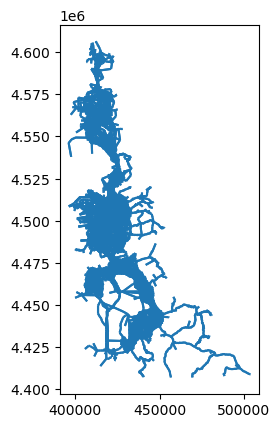

In [20]:
# display the gdf
gdf_tdm_link.plot()

<AxesSubplot:>

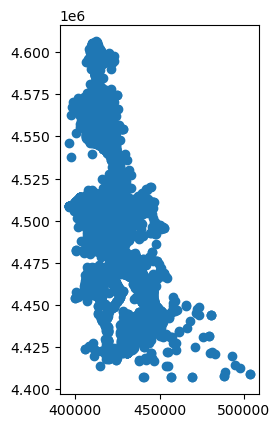

In [21]:
# display the gdf
gdf_tdm_node.plot()

In [22]:
# recalc link id because since it's not populated completely with changes.
gdf_tdm_link['LINKID'] = gdf_tdm_link['A'].astype(str) + '_' + gdf_tdm_link['B'].astype(str)

In [23]:
gdf_tdm_link = gdf_tdm_link[['A','B','LINKID','geometry']]
gdf_tdm_link

,A,B,LINKID,geometry
0,1,29685,1_29685,"LINESTRING (411935.000 4605642.000, 412478.126..."
1,2,29685,2_29685,"LINESTRING (412641.000 4606013.000, 412478.126..."
2,3,29645,3_29645,"LINESTRING (408993.000 4603544.000, 409632.415..."
3,4,29671,4_29671,"LINESTRING (410051.000 4604806.000, 409642.112..."
4,5,29680,5_29680,"LINESTRING (413394.000 4603600.000, 413482.000..."
...,...,...,...,...
57805,95064,95025,95064_95025,"LINESTRING (473181.550 4444171.200, 473172.240..."
57806,95064,95026,95064_95026,"LINESTRING (473181.550 4444171.200, 473177.690..."
57807,95064,95056,95064_95056,"LINESTRING (473181.550 4444171.200, 473196.790..."
57808,95065,3621,95065_3621,"LINESTRING (480730.710 4444037.000, 480767.876..."


In [24]:
df_project_transit_nodes

,project_id,node_id,is_stop
1256,1,66822,True
1280,1,66744,True
1284,1,66770,True
1289,1,66788,True
1297,1,50024,True
...,...,...,...
152395,206,20666,True
152398,206,20900,True
152404,206,21103,True
152408,206,21088,True


In [25]:
df_project_transit_nodes

,project_id,node_id,is_stop
1256,1,66822,True
1280,1,66744,True
1284,1,66770,True
1289,1,66788,True
1297,1,50024,True
...,...,...,...
152395,206,20666,True
152398,206,20900,True
152404,206,21103,True
152408,206,21088,True


,A,B,LINKID,geometry,project_id,link_id
0,3612,20869,3612_20869,"LINESTRING (396033.706 4508465.144, 396180.581...",197,3612_20869
1,10001,10002,10001_10002,"LINESTRING (421814.088 4477329.518, 421780.895...",20,10001_10002
2,10001,10002,10001_10002,"LINESTRING (421814.088 4477329.518, 421780.895...",20,10001_10002
3,10001,51010,10001_51010,"LINESTRING (421814.088 4477329.518, 421935.591...",20,10001_51010
4,10001,51010,10001_51010,"LINESTRING (421814.088 4477329.518, 421935.591...",20,10001_51010
...,...,...,...,...,...,...
44805,90130,90131,90130_90131,"LINESTRING (445663.900 4493357.700, 445764.200...",145,90130_90131
44806,90131,90130,90131_90130,"LINESTRING (448079.600 4492317.100, 448067.100...",145,90131_90130
44807,90131,90130,90131_90130,"LINESTRING (448079.600 4492317.100, 448067.100...",145,90131_90130
44808,90131,90130,90131_90130,"LINESTRING (448079.600 4492317.100, 448067.100...",145,90131_90130


,N,X,Y,GEOGKEY,EXTERNAL,HOTZN,TAZID,NODENAME,PNR_2015,PNR_2019,...,FARZN23_50,FARE23_32U,FARE23_42U,FARE23_50U,MAG_NODE,WFRC_NODE,geometry,project_id,node_id,is_stop
0,3612,396033.7063,4508465.144,396033_4508465,1,0,3612,I-80 to Tooele,0,0,...,0,0,0,0,0,1,POINT (396033.706 4508465.144),197,3612,True
1,10008,423401.1517,4485422.991,423401_4485422,0,0,2117,Draper,40,80,...,11,11,11,11,0,1,POINT (423401.152 4485422.991),20,10008,True
2,10008,423401.1517,4485422.991,423401_4485422,0,0,2117,Draper,40,80,...,11,11,11,11,0,1,POINT (423401.152 4485422.991),20,10008,True
3,10008,423401.1517,4485422.991,423401_4485422,0,0,2117,Draper,40,80,...,11,11,11,11,0,1,POINT (423401.152 4485422.991),95,10008,True
4,10008,423401.1517,4485422.991,423401_4485422,0,0,2117,Draper,40,80,...,11,11,11,11,0,1,POINT (423401.152 4485422.991),95,10008,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13940,90130,445663.9000,4493357.700,445663_4493357,0,0,2196,NaN,0,0,...,0,0,0,0,0,1,POINT (445663.900 4493357.700),145,90130,True
13941,90131,448079.6000,4492317.100,448079_4492317,0,0,2215,NaN,0,0,...,0,0,0,0,0,1,POINT (448079.600 4492317.100),145,90131,True
13942,90131,448079.6000,4492317.100,448079_4492317,0,0,2215,NaN,0,0,...,0,0,0,0,0,1,POINT (448079.600 4492317.100),145,90131,True
13943,90131,448079.6000,4492317.100,448079_4492317,0,0,2215,NaN,0,0,...,0,0,0,0,0,1,POINT (448079.600 4492317.100),145,90131,True


<AxesSubplot:>

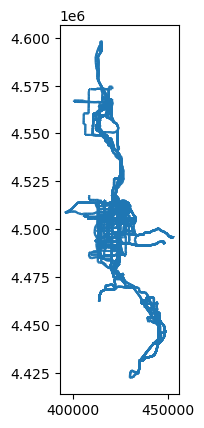

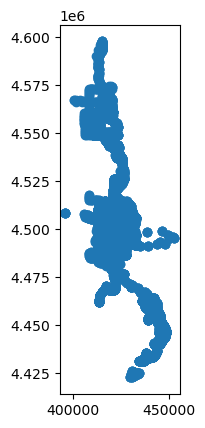

In [26]:
gdf_tdm_link_with_projects = pd.merge(gdf_tdm_link, df_project_transit_links, left_on='LINKID', right_on='link_id')
display(gdf_tdm_link_with_projects)
gdf_tdm_link_with_projects.plot()

gdf_tdm_node_with_projects = pd.merge(gdf_tdm_node, df_project_transit_nodes, left_on='N', right_on='node_id')
display(gdf_tdm_node_with_projects)
gdf_tdm_node_with_projects.plot()

In [28]:
df_centers

,center_type,FAR,bldg_size,size_of_hh_units,sf_per_employee,units_per_acre,sf_per_acre,%_residential,%_non_res,"gross_to_net_conversion_(streets,_etc)",final_units_per_acre,final_emps_per_acre,application_area,application_area_miles,household_size,office_retail_split
0,Neighborhood Center,0.6,26136,1000,500,26.136,52.27,0.85,0.15,0.8,18,6,1/8 mile radius,0.125,1.62,20/80
1,City Center,1.13,49222.8,850,450,57.909176,109.38,0.85,0.15,0.8,39,13,990 foot radius,0.1875,1.62,30/70
2,Urban Center,1.5,65340,750,400,87.12,163.35,0.85,0.15,0.8,59,20,1/4 mile radius,0.25,1.62,40/60
3,Metropolitan Center,2.0,86734,650,350,133.43,247.81,0.85,0.15,0.8,91,30,1/3 mile radius,0.3333,1.62,50/50


In [18]:
#gdf_buffered_projects_by_center_type = gpd.GeoDataFrame()
#
#for index, row in df_centers.iterrows():
#    print(row['center type'])
#
#    # Merging lines based on 'project_id'
#    _gdf_tdm_link_with_projects_merged = gdf_tdm_link_with_projects.dissolve(by='project_id')
#    _gdf_tdm_link_with_projects_merged['center type'] = row['center type']
#
#    # Buffer the merged lines by 'application area miles'
#    # Convert miles to an appropriate unit if your CRS is not in miles
#    # For example, if CRS is in meters, convert miles to meters (1 mile = 1609.34 meters)
#    _gdf_tdm_link_with_projects_merged['buffered'] = _gdf_tdm_link_with_projects_merged.geometry.buffer(row['application area miles'] * 1609.34)
#
#    # If you want the buffered geometry as the main geometry
#    _gdf_tdm_link_with_projects_merged.set_geometry('buffered', inplace=True)
#
#    _gdf_tdm_link_with_projects_merged.drop(columns=['geometry','A','B','LINKID','link_id'], inplace=True)
#    _gdf_tdm_link_with_projects_merged.reset_index(inplace=True)
#
#    _gdf_tdm_link_with_projects_merged.plot()
#
#    gdf_buffered_projects_by_center_type = pd.concat([gdf_buffered_projects_by_center_type,_gdf_tdm_link_with_projects_merged])
#
#display(gdf_buffered_projects_by_center_type)

,OBJECTID,AreaName,AreaType,Area,Shape__Area,Shape__Length,geometry
3,28,Canyons,Neighborhood Center,Summit County,4.571034e+05,2580.425872,"POLYGON ((452906.669 4504138.938, 453337.539 4..."
4,35,Crossroads,City Center,Utah County,3.847764e+06,8225.990373,"POLYGON ((421588.154 4469656.985, 421588.155 4..."
5,39,Deer Valley Base,Neighborhood Center,Summit County,1.626199e+05,2318.218626,"POLYGON ((459498.130 4499177.318, 459512.730 4..."
7,43,Downtown Provo,Urban Center,Utah County,1.267076e+07,30147.565078,"POLYGON ((444202.107 4456362.513, 444206.567 4..."
8,46,Downtown Springville,City Center,Utah County,2.891819e+06,13102.452873,"POLYGON ((445119.776 4446055.292, 447868.307 4..."
...,...,...,...,...,...,...,...
296,511,Cottonwood Village,Neighborhood Center,WFRC MPO,1.275807e+05,1603.672031,"POLYGON ((428976.795 4502431.078, 428978.502 4..."
297,512,Independence,City Center,WFRC MPO,5.686543e+06,11136.244285,"POLYGON ((420920.227 4479707.977, 420935.444 4..."
298,513,Porter Rockwell,Urban Center,WFRC MPO,4.110667e+06,10191.341842,"POLYGON ((423145.110 4480905.812, 423142.073 4..."
299,514,Washington Terrace US 89,City Center,WFRC MPO,1.478004e+06,7268.026224,"POLYGON ((418306.763 4557002.282, 418306.874 4..."


<AxesSubplot:>

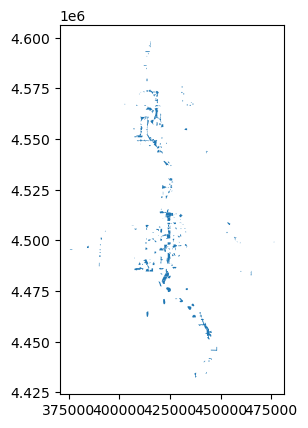

In [33]:
# read in wasatch choice center dataset and convert to UTM Zone 12N
gdf_wc_centers = gpd.read_file('input/wasatch-choice-centers/wc-centers.geojson')
gdf_wc_centers = gdf_wc_centers.to_crs(26912)

# filter for area types 
# Get the unique center types from df_centers
center_types = df_centers['center_type'].unique()

# Filter gdf_wc_centers based on the center types
gdf_filtered_centers = gdf_wc_centers[gdf_wc_centers['AreaType'].isin(center_types)]

display(gdf_filtered_centers)
display(gdf_filtered_centers.plot())

In [30]:
gdf_wc_centers.groupby(['AreaType']).count()

,OBJECTID,AreaName,Area,Shape__Area,Shape__Length,geometry
AreaType,,,,,,
City Center,90,90,90,90,90,90
Educational Center,10,10,10,10,10,10
Employment District,28,28,28,28,28,28
Industrial District,28,28,28,28,28,28
Metropolitan Center,2,2,2,2,2,2
Neighborhood Center,112,112,112,112,112,112
Special District,10,10,10,10,10,10
Urban Center,22,22,22,22,22,22


In [38]:
import geopandas as gpd
import pandas as pd

# Conversion factor from meters to miles
conversion_factor = 0.000621371

# Function to find the nearest stop (point) for each polygon
def find_nearest_stop(polygon_gdf, stop_gdf, conversion_factor=1):
    temp_df_list = []
    
    for polygon_idx, polygon in polygon_gdf.iterrows():
        # Calculate distance from the current polygon to all stops
        stop_gdf['distance'] = stop_gdf.geometry.apply(lambda geom: polygon.geometry.distance(geom))
        # Find the index of the nearest stop
        nearest_stop_idx = stop_gdf['distance'].idxmin()
        # Convert distance to miles
        distance_in_miles = stop_gdf.loc[nearest_stop_idx, 'distance'] * conversion_factor
        
        # Append results
        temp_df_list.append({
            'polygon_index': polygon_idx,
            'stop_index': nearest_stop_idx,
            'distance_in_miles': distance_in_miles
        })
    
    # Combine results into a DataFrame
    return pd.DataFrame(temp_df_list)

# Find nearest stops for each polygon
find_nearest_stop_df = find_nearest_stop(gdf_filtered_centers, gdf_tdm_node_with_projects, conversion_factor)

# Join the nearest stop info back to the original polygon GeoDataFrame
gdf_nearest_stops = gdf_filtered_centers.join(
    find_nearest_stop_df.set_index('polygon_index')['stop_index'], how='left'
).merge(
    gdf_tdm_node_with_projects.rename(columns=lambda x: f'nearest_{x}'),
    left_on='stop_index', right_index=True, how='left'
).join(
    find_nearest_stop_df.set_index('polygon_index')['distance_in_miles'], how='left'
)
display(gdf_nearest_stops)

,OBJECTID,AreaName,AreaType,Area,Shape__Area,Shape__Length,geometry,stop_index,nearest_N,nearest_X,...,nearest_FARE23_42U,nearest_FARE23_50U,nearest_MAG_NODE,nearest_WFRC_NODE,nearest_geometry,nearest_project_id,nearest_node_id,nearest_is_stop,nearest_distance,distance_in_miles
3,28,Canyons,Neighborhood Center,Summit County,4.571034e+05,2580.425872,"POLYGON ((452906.669 4504138.938, 453337.539 4...",13909,90123,449720.1000,...,0,0,0,1,POINT (449720.100 4497140.800),147,90123,True,25258.260179,4.460434
4,35,Crossroads,City Center,Utah County,3.847764e+06,8225.990373,"POLYGON ((421588.154 4469656.985, 421588.155 4...",11394,62316,422204.8756,...,0,0,1,0,POINT (422204.876 4469444.976),132,62316,True,34118.586689,0.000000
5,39,Deer Valley Base,Neighborhood Center,Summit County,1.626199e+05,2318.218626,"POLYGON ((459498.130 4499177.318, 459512.730 4...",13921,90126,452854.5000,...,0,0,0,1,POINT (452854.500 4495651.400),147,90126,True,28673.669757,4.470462
7,43,Downtown Provo,Urban Center,Utah County,1.267076e+07,30147.565078,"POLYGON ((444202.107 4456362.513, 444206.567 4...",11200,50024,443771.3641,...,21,21,1,0,POINT (443771.364 4452975.470),1,50024,True,53778.774189,0.000000
8,46,Downtown Springville,City Center,Utah County,2.891819e+06,13102.452873,"POLYGON ((445119.776 4446055.292, 447868.307 4...",12160,66517,447998.2500,...,0,0,1,0,POINT (447998.250 4445815.869),5,66517,True,61974.550198,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,511,Cottonwood Village,Neighborhood Center,WFRC MPO,1.275807e+05,1603.672031,"POLYGON ((428976.795 4502431.078, 428978.502 4...",5099,24533,428997.1960,...,0,0,0,1,POINT (428997.196 4502426.202),157,24533,True,3873.087837,0.010519
297,512,Independence,City Center,WFRC MPO,5.686543e+06,11136.244285,"POLYGON ((420920.227 4479707.977, 420935.444 4...",1098,20687,422015.8295,...,0,0,0,1,POINT (422015.829 4480782.335),190,20687,True,22858.968632,0.000000
298,513,Porter Rockwell,Urban Center,WFRC MPO,4.110667e+06,10191.341842,"POLYGON ((423145.110 4480905.812, 423142.073 4...",995,20446,421116.6961,...,0,0,0,1,POINT (421116.696 4479684.613),190,20446,True,24071.389191,0.000000
299,514,Washington Terrace US 89,City Center,WFRC MPO,1.478004e+06,7268.026224,"POLYGON ((418306.763 4557002.282, 418306.874 4...",9867,28381,418416.0000,...,0,0,0,1,POINT (418416.000 4558354.000),122,28381,True,53653.638612,0.004142


In [ ]:
# Prepare the final DataFrame
df_nearest_stops = gdf_nearest_stops.copy()
df_nearest_stops = df_nearest_stops[df_nearest_stops['distance_in_miles']<0.5]
df_nearest_stops = df_nearest_stops[['AreaName', 'AreaType', 'distance_in_miles']]

# Display the result
display(df_nearest_stops)

,AreaName,AreaType,distance_in_miles
4,Crossroads,City Center,0.000000
7,Downtown Provo,Urban Center,0.000000
8,Downtown Springville,City Center,0.000000
9,Eagle Mountain,City Center,0.000000
17,Hillcrest,City Center,0.000000
...,...,...,...
296,Cottonwood Village,Neighborhood Center,0.010519
297,Independence,City Center,0.000000
298,Porter Rockwell,Urban Center,0.000000
299,Washington Terrace US 89,City Center,0.004142


<AxesSubplot:>

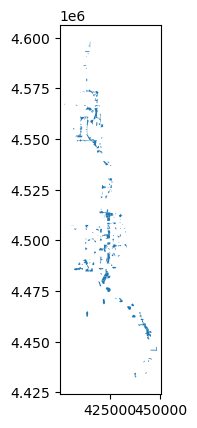

In [45]:
gdf_nearest_stops_within_half_mile = gdf_nearest_stops[gdf_nearest_stops['distance_in_miles']<0.5]
gdf_nearest_stops_within_half_mile.plot()

<AxesSubplot:>

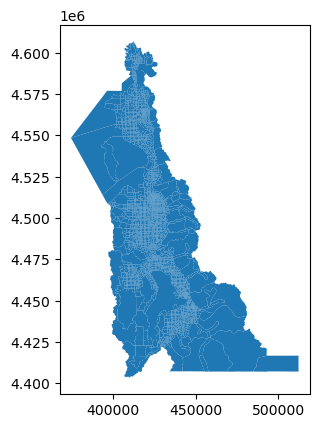

In [46]:
# import taz shapefile
gdf_taz = gpd.read_file(os.path.join(input_taz_shapefile_folder, taz_shapefile))
gdf_taz.rename(columns={'ACRES':'TAZACRES'}, inplace=True)
gdf_taz = gdf_taz.to_crs(26912)
gdf_taz.plot()

,AreaName,AreaType,Area,TAZID,CO_FIPS,TAZACRES,sqm,acres,geometry
0,Crossroads,City Center,Utah County,2496,49,165.490872,306078.979084,75.633763,"POLYGON ((421958.924 4468475.185, 421704.024 4..."
1,Crossroads,City Center,Utah County,2503,49,85.734122,185231.805669,45.771776,"POLYGON ((422468.715 4468706.905, 422213.825 4..."
2,Crossroads,City Center,Utah County,2504,49,146.410140,82.317025,0.020341,"POLYGON ((422640.942 4469115.927, 422641.047 4..."
3,Crossroads,City Center,Utah County,2505,49,76.823967,167718.011467,41.444023,"POLYGON ((422654.105 4469147.185, 422649.306 4..."
4,Crossroads,City Center,Utah County,2498,49,112.631810,268457.440292,66.337278,"POLYGON ((421588.154 4469911.650, 421669.151 4..."
...,...,...,...,...,...,...,...,...,...
1224,Meadowbrook Station,City Center,WFRC MPO,1492,35,45.728115,149005.282516,36.820007,"POLYGON ((424235.616 4505014.079, 424269.116 4..."
1225,Meadowbrook Station,City Center,WFRC MPO,1493,35,50.633831,109626.735660,27.089356,"MULTIPOLYGON (((424462.516 4504848.479, 424705..."
1226,Meadowbrook Station,City Center,WFRC MPO,1494,35,50.381448,108708.827297,26.862536,"POLYGON ((424715.708 4504846.582, 424945.987 4..."
1227,Meadowbrook Station,City Center,WFRC MPO,1495,35,88.369280,93800.997173,23.178731,"POLYGON ((424961.771 4504845.920, 424963.041 4..."


<AxesSubplot:>

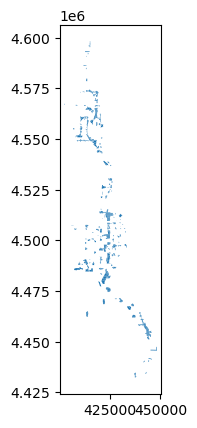

In [54]:
# Assuming gdf1, gdf2, and gdf3 are your GeoDataFrames

# Perform the intersection of the first two GeoDataFrames
gdf_centers_taz = gpd.overlay(gdf_nearest_stops_within_half_mile, gdf_taz[['TAZID','TAZACRES','CO_FIPS','geometry']], how='intersection')

# Calculate the area in square meters
gdf_centers_taz['sqm'] = gdf_centers_taz.geometry.area

# Convert the area to acres
gdf_centers_taz['acres'] = gdf_centers_taz['sqm'] / 4046.85642

gdf_centers_taz = gdf_centers_taz[['AreaName','AreaType','Area','TAZID','CO_FIPS','TAZACRES','sqm','acres','geometry']]

# The final_intersection GeoDataFrame now contains the intersection of all three GeoDataFrames
display(gdf_centers_taz)
gdf_centers_taz.plot()


In [56]:
gdf_centers_taz.to_file("intermediate/centers-taz.geojson", format='geojson')
print('Exported')

Exported


In [57]:
gdf_taz_export = gdf_taz[['TAZID','geometry']]
gdf_taz_export = gdf_taz_export.to_crs(epsg=4326)
gdf_taz_export.to_file('_site/data/taz.geojson')


In [58]:
gdf_wc_centers_export = gdf_filtered_centers
gdf_wc_centers_export = gdf_wc_centers_export.to_crs(epsg=4326)
gdf_wc_centers_export.to_file('_site/data/wc_centers.geojson')